## Create a hollow sphere as a sample object

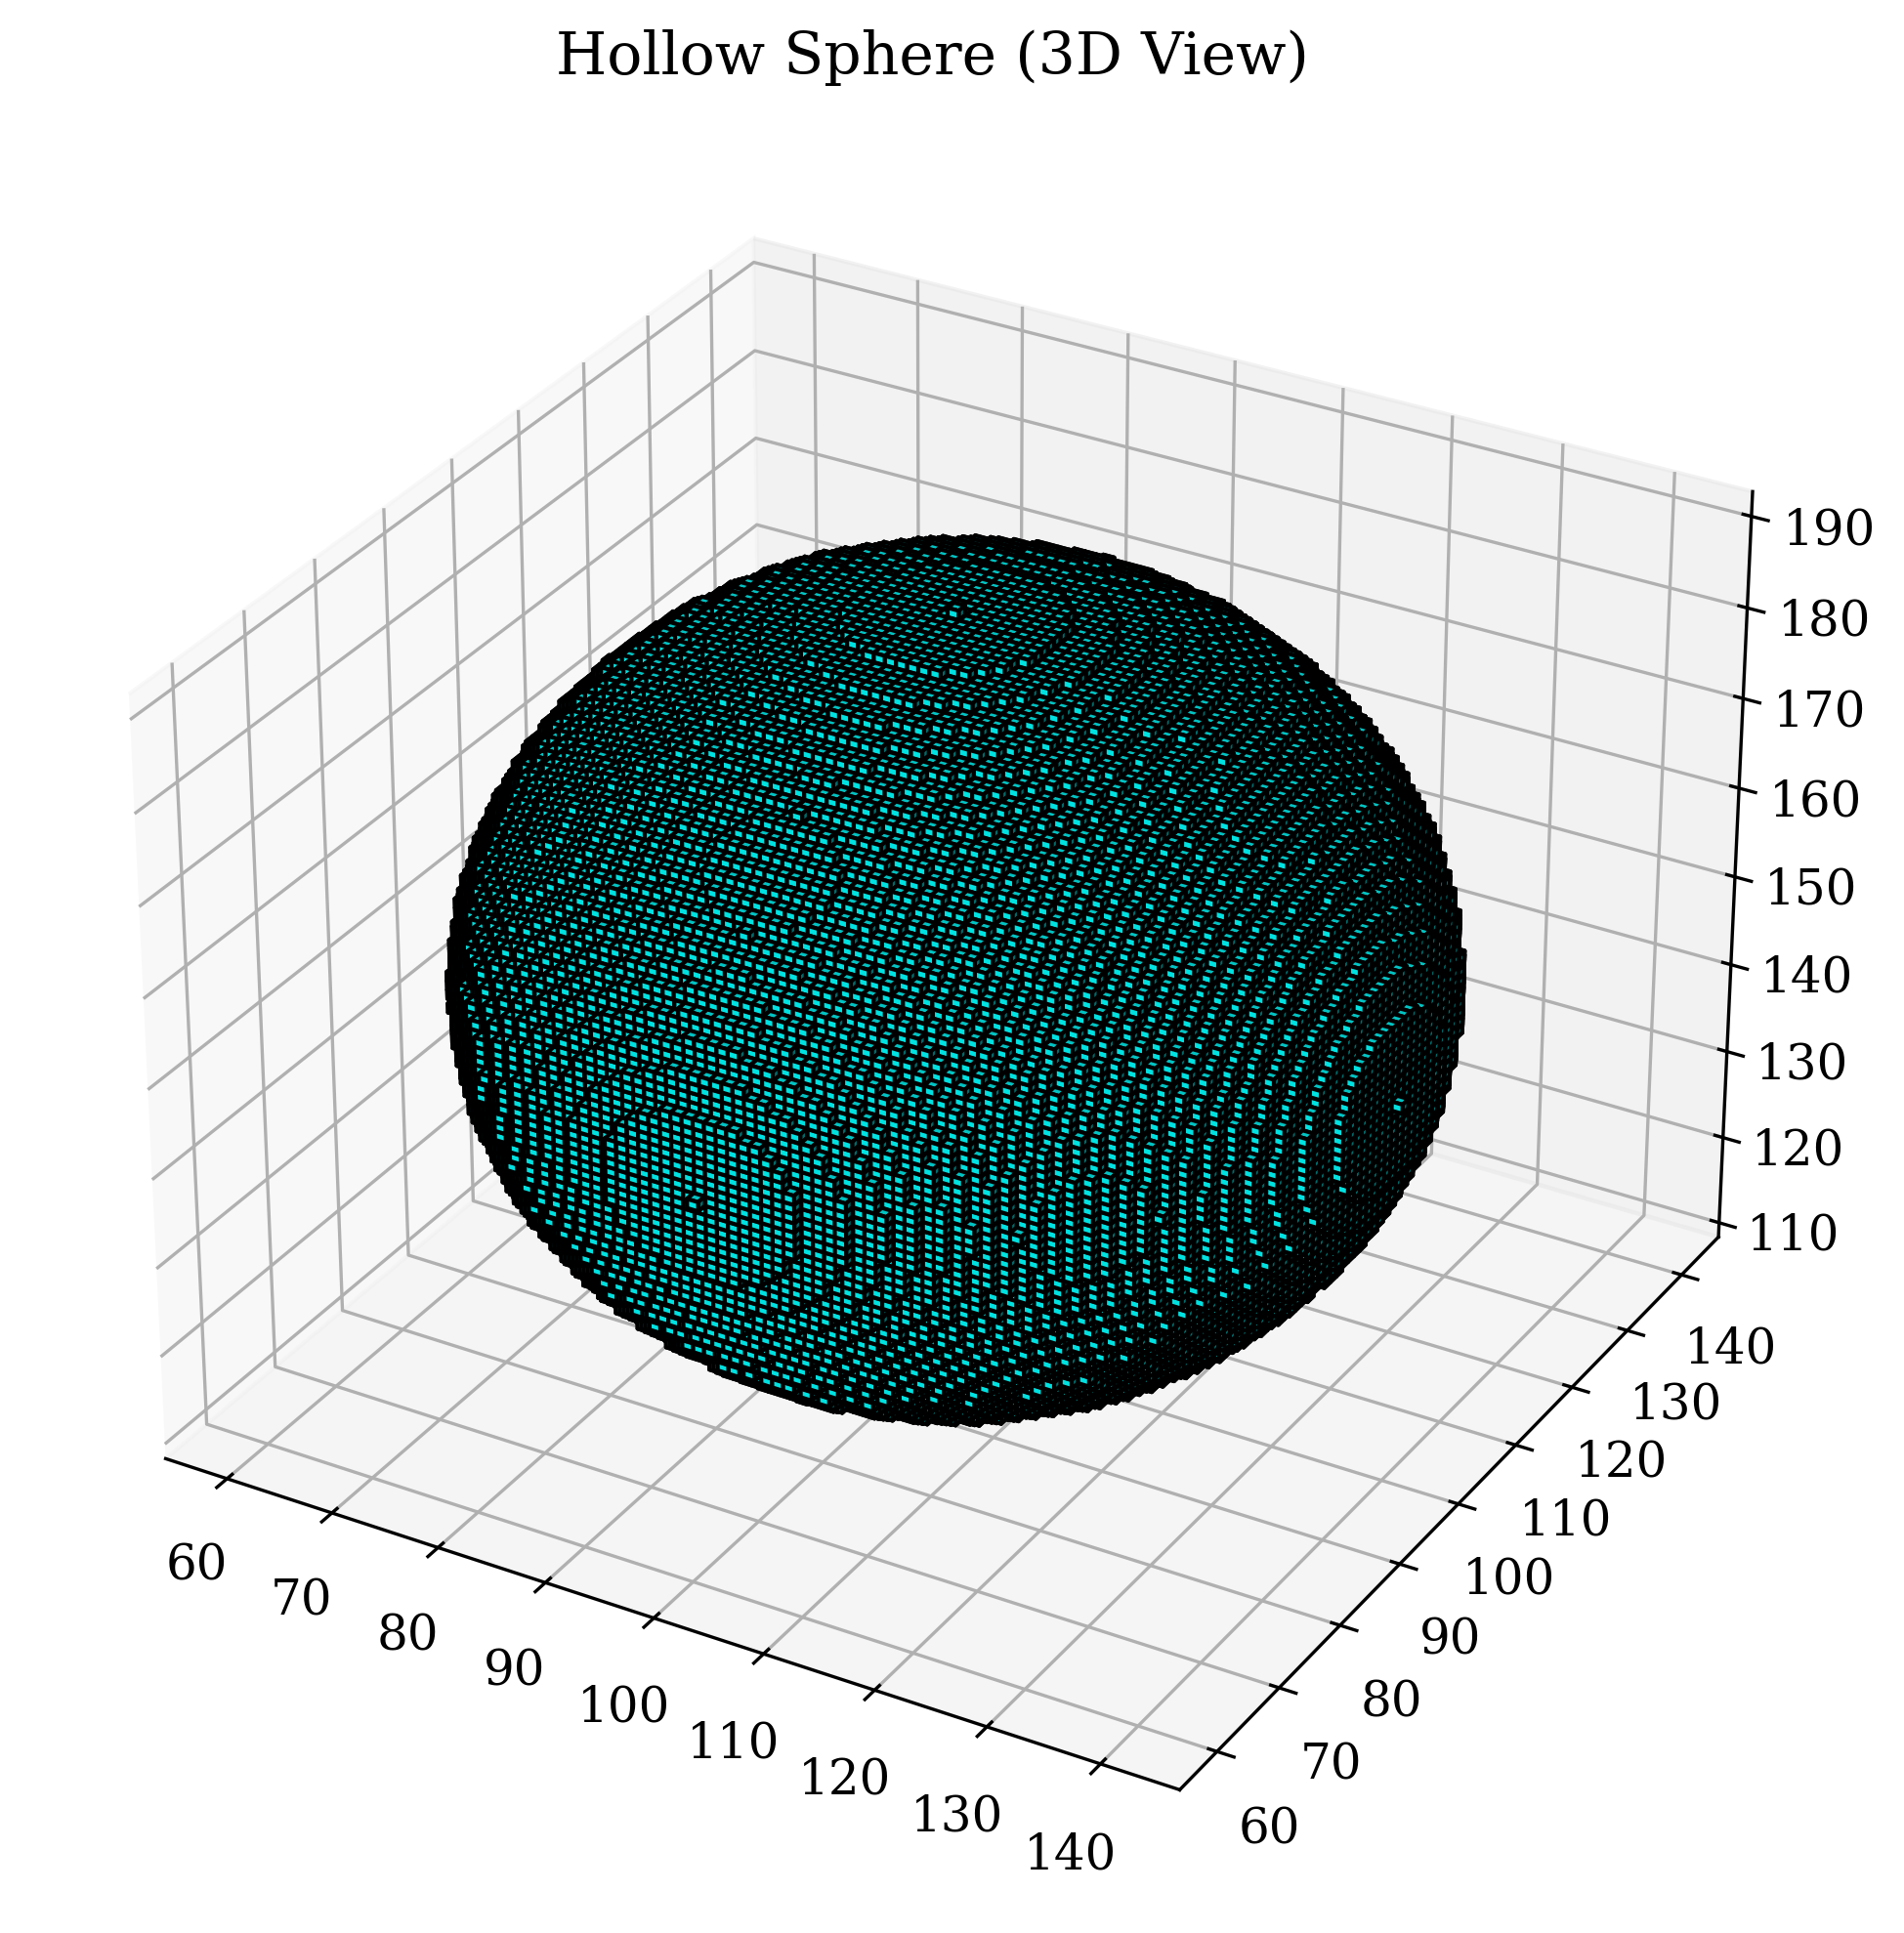

Successfully saved the 3D image to: hollow_sphere.nii.gz


In [4]:

import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import nibabel as nib
import matplotlib as mpl

mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 12

image_size = [200, 200, 300]
center = [100, 100, 150]
numpy_array = np.zeros(image_size, dtype=np.uint8) 
z, y, x = np.ogrid[0:image_size[0], 0:image_size[1], 0:image_size[2]] 

outer_radius = 40
inner_radius = 30

outer_sphere_mask = (x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2 <= outer_radius**2
inner_sphere_mask = (x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2 <= inner_radius**2

hollow_sphere = outer_sphere_mask & ~inner_sphere_mask

numpy_array[hollow_sphere] = 1

fig = plt.figure(figsize=(8, 8),dpi =300)
ax = fig.add_subplot(111, projection='3d')
ax.voxels(numpy_array, facecolors='cyan', edgecolors='k')
ax.set_title('Hollow Sphere (3D View)')
plt.show()

affine = np.eye(4)
nifti_image = nib.Nifti1Image(numpy_array, affine)
output_filename = 'hollow_sphere.nii.gz'
nib.save(nifti_image, output_filename)

print(f"Successfully saved the 3D image to: {output_filename}")



## Find the thisckness

In [ ]:
## Quick way to calculate thickness and visualize. But not accurate.
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import nibabel as nib 
import matplotlib as mpl
import os 

mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 12

plot_path = "/Users/dbattagodage/Desktop/Datasets/Image_Analysis/thickness/plots"
image_path = "/Users/dbattagodage/Desktop/Datasets/Image_Analysis/thickness/Tissue_image"
label_dict = {1:"Myocardium", 2:"Endocardium", 3:"Lumen",4:"ECM"}

def calculate_and_visualize_thickness(segmentation_filepath, label_of_interest):
    img_id = segmentation_filepath.split('/')[-1].split('.')[0]
    nifti_image = nib.load(segmentation_filepath)
    segmentation_data = nifti_image.get_fdata()

    max_thickness_per_slice = []
    image_size = segmentation_data.shape

    # fig , ax = plt.subplots(figsize=(8, 6))

    for z in range(image_size[2]):
        slice_data = segmentation_data[:, :, z]
        binary_mask = (slice_data == label_of_interest).astype(np.uint8)
        if np.sum(binary_mask) == 0:
            max_thickness_per_slice.append(0)
            continue
        else:
            distance_array = ndimage.distance_transform_edt(binary_mask,sampling=[0.27,0.27])
            
            shell_distances = distance_array[binary_mask == 1]

            max_radius = np.max(shell_distances) 
            max_thickness = max_radius * 2
            max_thickness_per_slice.append(max_thickness)
        
        if z == image_size[2] // 2:

            fig, ax = plt.subplots(1,2,figsize=(15, 5), dpi=300)

            ax[0].imshow(binary_mask, cmap='gray')
            ax[0].set_title(f'Binary Mask (Slice {z})')
            # plt.colorbar(ax[0].imshow(binary_mask, cmap='gray'), ax=ax[0], label='Mask Value')

            ax[1].imshow(distance_array, cmap='viridis')
            ax[1].set_title('Distance Transform Map')
            plt.colorbar(ax[1].imshow(distance_array, cmap='viridis'), ax=ax[1], label='Distance to boundary)')
            
            plt.suptitle(f'Thickness Visualization: {img_id}_{label_dict[label_of_interest]}')
            # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            fig.savefig(os.path.join(image_path, f'{img_id}_{label_dict[label_of_interest]}_slice_{z}.pdf'))
            # plt.show()
            
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(max_thickness_per_slice, marker='.', color = 'green')
    plt.title(f'{img_id}_{label_dict[label_of_interest]}')
    plt.xlabel('Slice Index (Z-axis)')
    plt.ylabel(r'Maximum Thickness ($\mu$m)')
    plt.savefig(os.path.join(plot_path, f'{img_id}_{label_dict[label_of_interest]}_thickness_plot.pdf'))

In [ ]:
## Correct way to calculate thickness and visualize.

import numpy as np
from scipy import ndimage
from skimage.morphology import medial_axis
from skimage.measure import label, regionprops
import nibabel as nib
import matplotlib.pyplot as plt
import os 
import matplotlib as mpl    
import math

mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 12

plot_path = "/home/cellsmb/Desktop/Dinuka/Image_Analysis/Thickness/plots"
image_path = "/home/cellsmb/Desktop/Dinuka/Image_Analysis/Thickness/Tissue_image"
label_dict = {2:"Myocardium", 3:"Endocardium", 4:"Lumen",5:"ECM"}


def measure_component_thickness(mask):
    
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    all_mean_thicknesses = []
    all_max_thicknesses = []
    all_min_thicknesses = []

    for region in regions:

        component_mask = labeled_mask == region.label
        distance_array_mm = ndimage.distance_transform_edt(component_mask,sampling=[0.27,0.27])
        skeleton = medial_axis(component_mask)
        thicknesses = distance_array_mm[skeleton] * 2
        mean_thickness = np.mean(thicknesses)
        max_thickness = np.max(thicknesses)
        min_thickness = np.min(thicknesses)

        all_mean_thicknesses.append(mean_thickness)
        all_max_thicknesses.append(max_thickness)
        all_min_thicknesses.append(min_thickness)



        # cy, cx = region.centroid
        # h, w = region.image.shape
        # r_max = math.ceil(np.hypot(h/2, w/2))
        # thicknesses = []
    
        # for angle in np.linspace(0, 2 * np.pi, n_rays, endpoint=False):
        #     xs = cx + np.cos(angle) * np.arange(r_max)
        #     ys = cy + np.sin(angle) * np.arange(r_max)

        #     vals = ndimage.map_coordinates(component_mask.astype(float), [ys, xs], order=0)

        #     diffs = np.diff(vals)
        #     enter_points = np.where(diffs == 1)[0]
        #     exit_points = np.where(diffs == -1)[0]
        #     if len(enter_points) < len(exit_points):
        #         enter_points = np.insert(enter_points, 0, 0)

        #     if len(enter_points) > len(exit_points):
        #         exit_points = np.append(exit_points, r_max - 1)

        #     # Pair them up to get thickness segments
        #     for e, x in zip(enter_points, exit_points):
        #         if x > e:
        #             thicknesses.append(x - e)

        # if len(thicknesses) > 0:
        #     mean_thickness = np.mean(thicknesses)
        #     max_thickness = np.max(thicknesses)
        #     min_thickness = np.min(thicknesses)
        #     all_mean_thicknesses.append(mean_thickness)
        #     all_max_thicknesses.append(max_thickness)
        #     all_min_thicknesses.append(min_thickness)

    if len(all_mean_thicknesses) == 0:
        return 0.0,0,0

    return (np.mean(all_mean_thicknesses), np.max(all_max_thicknesses), np.min(all_min_thicknesses))

def measure_tissue_thickness(segmentation_filepath, label_of_interest):

    img_id = segmentation_filepath.split('/')[-1].split('.')[0]
    nifti_image = nib.load(segmentation_filepath)
    segmentation_data = nifti_image.get_fdata()

    max_thickness_per_slice = []
    avg_thickness_per_slice = []
    min_thickness_per_slice = []
    image_size = segmentation_data.shape
    plot_middle_slice = False

    for z in range(image_size[2]):
        # print(f"Processing slice {z+1}/{image_size[2]}")
        slice_data = segmentation_data[:, :, z]
        binary_mask = (slice_data == label_of_interest).astype(np.uint8)
        if np.sum(binary_mask) == 0:
            max_thickness_per_slice.append(0)
            avg_thickness_per_slice.append(0)
            min_thickness_per_slice.append(0)
            continue
        else:
            mean_thickness, max_thickness, min_thickness = measure_component_thickness(binary_mask)
            max_thickness_per_slice.append(max_thickness)
            avg_thickness_per_slice.append(mean_thickness)
            min_thickness_per_slice.append(min_thickness)
    
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(max_thickness_per_slice, marker='.', linestyle='-',color = 'green', label='Max Thickness')
    plt.plot(avg_thickness_per_slice, marker='.', linestyle='--',color = 'blue', label='Avg Thickness')
    # plt.plot([x*0.27 for x in min_thickness_per_slice], marker='.', linestyle=':',color = 'orange', label='Min Thickness')
    plt.title(f'{img_id}_{label_dict[label_of_interest]}')
    plt.xlabel('Slice Index (Z-axis)')
    plt.ylabel(r'Tissue Thickness ($\mu$m)')
    plt.legend()
    plt.savefig(os.path.join(plot_path, f'{img_id}_{label_dict[label_of_interest]}_thickness_plot.pdf'))
    plt.close()

In [ ]:
folder = "/home/cellsmb/Desktop/Dinuka/Image_Analysis/nnUnet_raw/labelsTr"
for file in os.listdir(folder):
    if file.endswith(".nii.gz"):
        print("Processing file:", file) 
        for label_id in [2,3]:
            measure_tissue_thickness(os.path.join(folder,file),label_id)

Processing file: IF_Tr_0002.nii.gz


## Testing

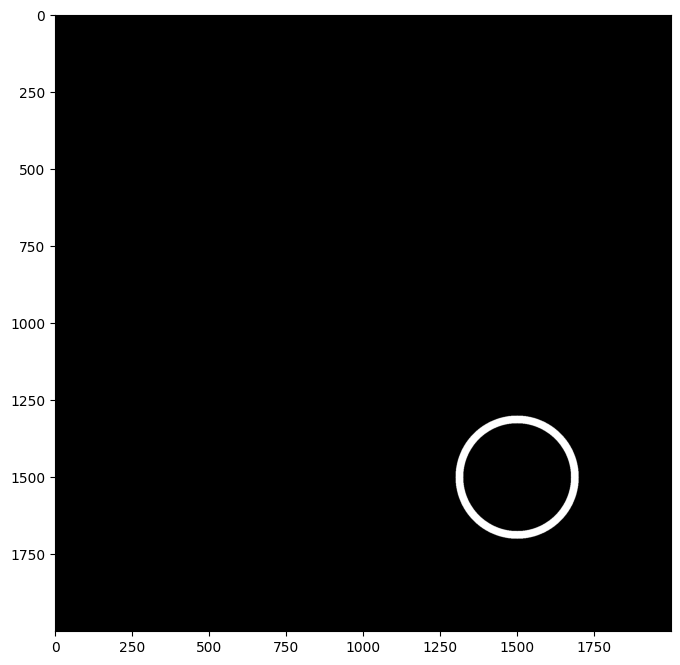

In [12]:
## Create test image with two hollow spheres
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy import ndimage
image_size = [2000, 2000]
center1 = [500, 500]
center2 = [1500, 1500]
numpy_array = np.zeros(image_size, dtype=np.uint8) 
y, x = np.ogrid[0:image_size[0], 0:image_size[1]] 

outer_radius1 = 400
inner_radius1 = 300

outer_radius2 = 200
inner_radius2 = 175

outer_sphere_mask1 = (x - center1[1])**2 + (y- center1[0])**2 <= outer_radius1**2
inner_sphere_mask1 = (x - center1[1])**2 + (y - center1[0])**2 <= inner_radius1**2

hollow_sphere1 = outer_sphere_mask1 & ~inner_sphere_mask1

outer_sphere_mask2 = (x - center2[1])**2 + (y- center2[0])**2 <= outer_radius2**2
inner_sphere_mask2 = (x - center2[1])**2 + (y - center2[0])**2 <= inner_radius2**2

hollow_sphere2 = outer_sphere_mask2 & ~inner_sphere_mask2
numpy_array[hollow_sphere2] = 1
# numpy_array[hollow_sphere1] = 1

fig = plt.figure(figsize=(8, 8))
plt.imshow(numpy_array, cmap='gray')



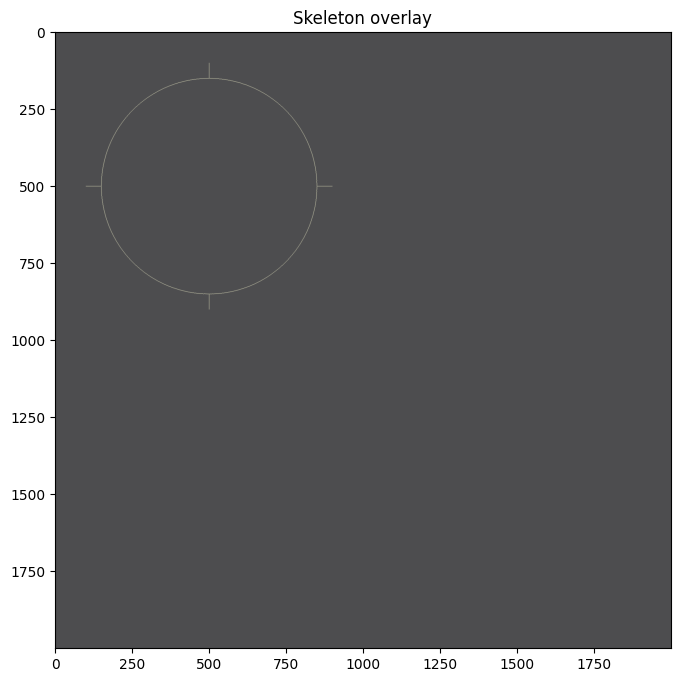

In [10]:
from skimage.morphology import medial_axis
import matplotlib.pyplot as plt

skeleton, dist = medial_axis(numpy_array, return_distance=True)

plt.figure(figsize=(8, 8))
# plt.imshow(numpy_array, cmap='gray')
plt.imshow(skeleton,cmap='magma', alpha=0.7)  # orange skeleton overlay
plt.title("Skeleton overlay")
plt.show()


Is distance array_mm and local_thickness the same? True
Mean: 24.42204790131843
Max: 26.0
Min: 2.0


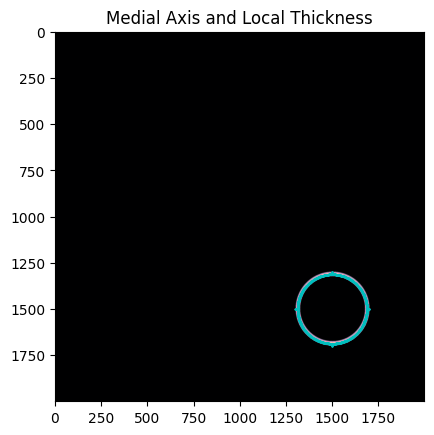

[1. 1. 1. ... 1. 1. 1.]
average_radius: 6.545144586994264
average_thickness: 13.090289173988529
max_radius: 13.0
max_thickness: 26.0


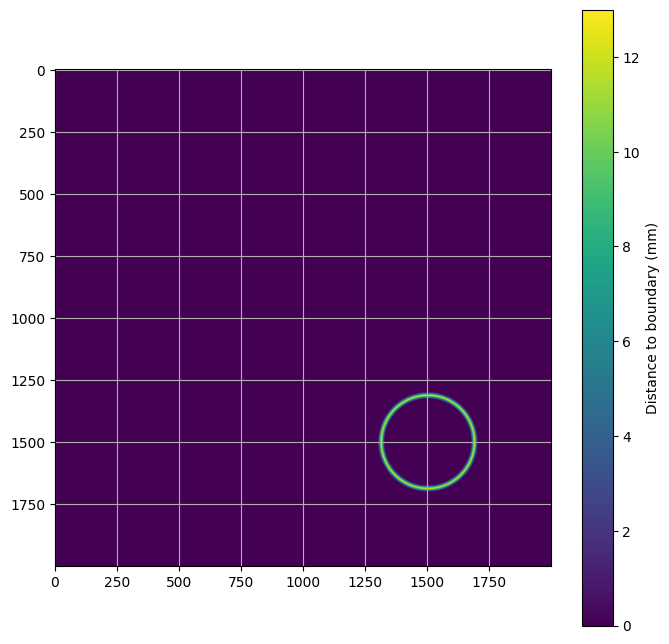

In [15]:
## Calculate distance transform and thickness metrics
bm = (numpy_array == 1)
distance_array_mm = ndimage.distance_transform_edt(bm)
from skimage.morphology import medial_axis
skeleton, dist_on_skeleton = medial_axis(bm, return_distance=True)

local_thickness = 2 * dist_on_skeleton[skeleton]
print("Is distance array_mm and local_thickness the same?",np.all(dist_on_skeleton==distance_array_mm))
# summary stats
mean_thickness = np.mean(local_thickness)
max_thickness = np.max(local_thickness)
min_thickness = np.min(local_thickness)

print("Mean:", mean_thickness)
print("Max:", max_thickness)
print("Min:", min_thickness)

# visualize
plt.imshow(bm, cmap='gray')
plt.imshow(distance_array_mm, cmap='magma', alpha=0.5)
plt.plot(np.where(skeleton)[1], np.where(skeleton)[0], 'c.', markersize=1)
plt.title("Medial Axis and Local Thickness")
plt.show()


fig = plt.figure(figsize=(8, 8))
img=plt.imshow(distance_array_mm, cmap='viridis')
plt.colorbar(img, label='Distance to boundary (mm)')
plt.grid(True)
shell_distances = distance_array_mm[bm==1]
print(shell_distances)    
average_radius = np.mean(shell_distances)
print('average_radius:', average_radius)
average_thickness = average_radius * 2
print('average_thickness:', average_thickness)
max_radius = np.max(shell_distances)
print('max_radius:', max_radius)
max_thickness = max_radius * 2
print('max_thickness:', max_thickness)

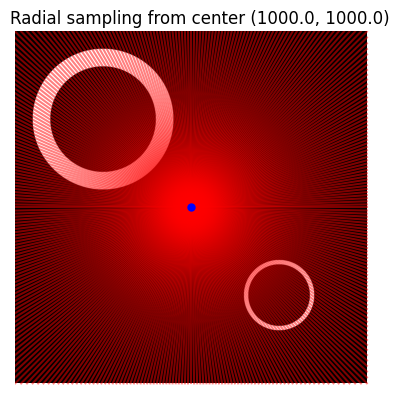

In [ ]:
## Radial thickness measurement with multiple segments along each ray. Common center for all rays.
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

def radial_thickness_multi(mask, n_rays=720, center=None, visualize=False):

    h, w = mask.shape
    if center is None:
        cx = w // 2
        cy = h // 2
    else:
        cx, cy = center

    angles = np.linspace(0, 2 * np.pi, n_rays, endpoint=False)
    all_thicknesses = []
    nb = 0
    for theta in angles:
        # Generate ray coordinates
        r_max = int(np.hypot(h/2, w/2))
        xs = cx + np.cos(theta) * np.arange(0, r_max)
        ys = cy + np.sin(theta) * np.arange(0, r_max)

        valid = (xs >= 0) & (ys >= 0) & (xs < w) & (ys < h)
        xs, ys = xs[valid], ys[valid]

        # Sample mask values along ray
        vals = ndimage.map_coordinates(mask.astype(float), [ys, xs], order=0)

        # Detect transitions (0→1 and 1→0)
        transitions = np.diff(vals.astype(int))
        entries = np.where(transitions == 1)[0] + 1
        exits = np.where(transitions == -1)[0] + 1
        # Handle edge cases (ray starts/ends inside tissue)
        if len(entries) > 0 and (len(exits) == 0 or exits[0] < entries[0]):
            exits = np.insert(exits, 0, 0)
        if len(exits) < len(entries):
            exits = np.append(exits, len(vals) - 1)

        # Compute all segment thicknesses
        for r1, r2 in zip(entries, exits):
            all_thicknesses.append(abs(r2 - r1))
        
        if visualize:
            plt.plot([cx, xs[-1]], [cy, ys[-1]], 'r-', alpha=0.5)

    mean_thickness = np.mean(all_thicknesses) if len(all_thicknesses) > 0 else 0

    if visualize:
        plt.imshow(mask, cmap='gray')
        plt.plot(cx, cy, 'bo', markersize=5)
        plt.title(f"Radial sampling from center ({cx:.1f}, {cy:.1f})")
        plt.axis('off')
        plt.show()

    return mean_thickness, np.array(all_thicknesses)


mean_thickness, thickness = radial_thickness_multi(bm, n_rays=360, visualize=True)


In [7]:
mean_thickness

107.88

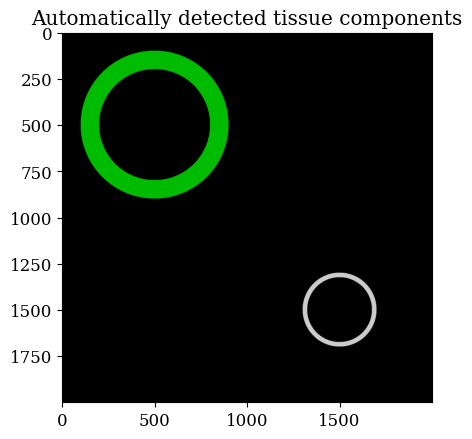

Detected 2 regions.


In [10]:
## Automatically detect tissue components and measure thickness
from skimage.measure import label, regionprops
import numpy as np  
import matplotlib.pyplot as plt

labeled_mask = label(bm)
plt.imshow(labeled_mask, cmap='nipy_spectral')
plt.title("Automatically detected tissue components")
plt.show()

regions = regionprops(labeled_mask)
print(f"Detected {len(regions)} regions.")

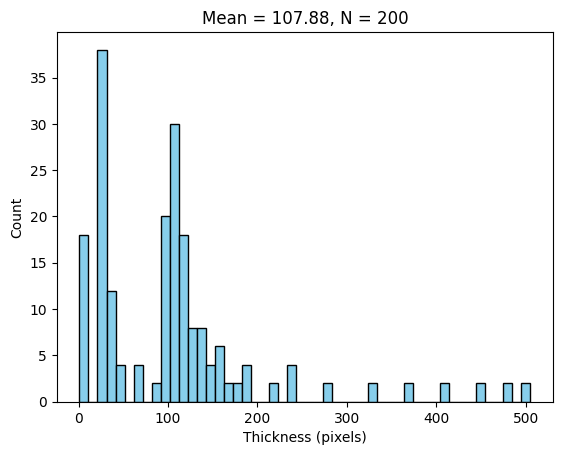

In [9]:
plt.hist(thickness, bins=50, color='skyblue', edgecolor='k')
plt.xlabel("Thickness (pixels)")
plt.ylabel("Count")
plt.title(f"Mean = {mean_thickness:.2f}, N = {len(thickness)}")
plt.show()


In [6]:
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img_path = "/home/cellsmb/Desktop/Dinuka/Image_Analysis/nnUnet_raw/labelsTr/IF_Tr_0006.nii.gz"
nifti_image = nib.load(img_path).get_fdata().astype(np.uint8)[:,:,486]
bm = (nifti_image == 2).astype(np.uint8)  # Example: binary mask for label 1

labeled_mask = label(bm)
regions = regionprops(labeled_mask)
unique, counts = np.unique(labeled_mask, return_counts=True)
# Skip background (label 0)
region_id = unique[1:][np.argmax(counts[1:])]

Detected 8 regions.
Region 0 centroid: (np.float64(1037.559868423566), np.float64(1083.0355798876024))
Region 0 bbox: (497, 256, 1467, 1765)
Region 0 shape: (970, 1509)


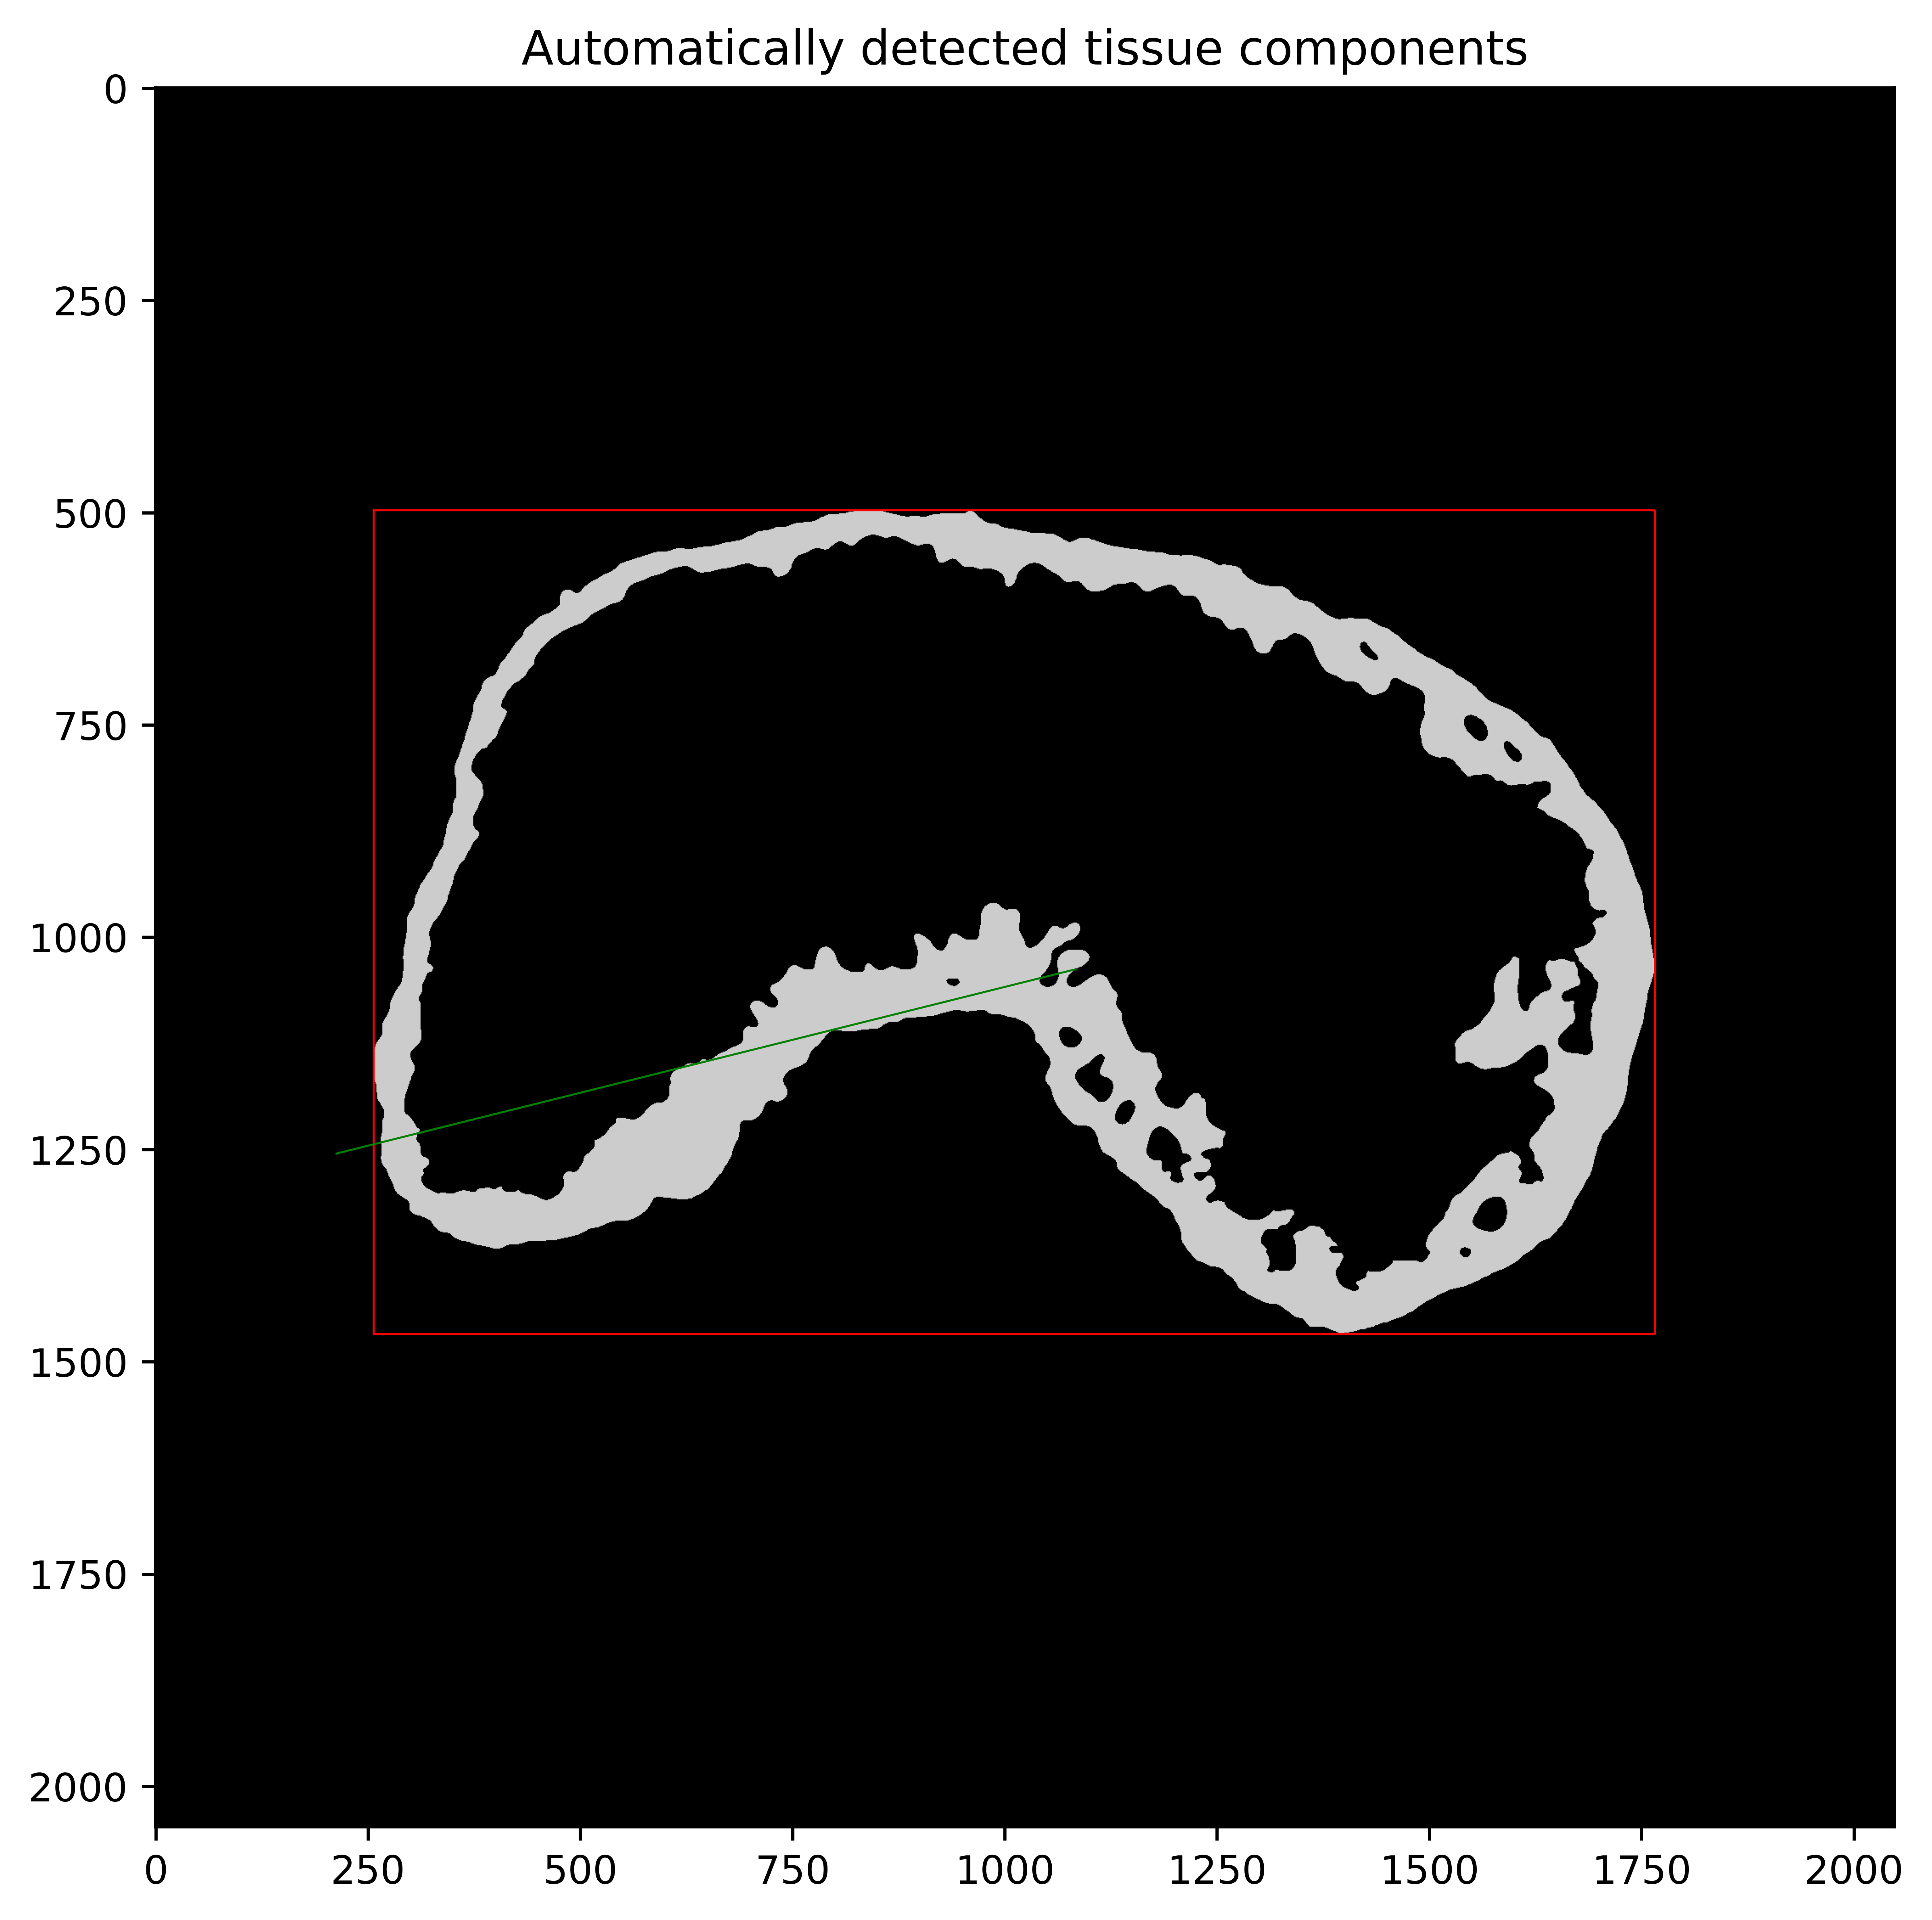

In [7]:
region_id= 0
region_mask = labeled_mask == region_id+1

min_raw, min_col, max_raw, max_col = regions[region_id].bbox
print(f"Detected {len(regions)} regions.")
print(f"Region {region_id} centroid: {regions[region_id].centroid}")
print(f"Region {region_id} bbox: {regions[region_id].bbox}")
print(f"Region {region_id} shape: {regions[region_id].image.shape}")
angle = 2.897246558310587
cy, cx = regions[region_id].centroid
h,w = regions[region_id].image.shape
r_max = math.ceil(np.hypot(h/2, w/2))
# Compute end point of the line
x_end = cx + r_max * math.cos(angle)
y_end = cy + r_max * math.sin(angle)
plt.figure(figsize=(8, 8),dpi=700)
plt.imshow(region_mask, cmap='nipy_spectral')

plt.plot([min_col, max_col, max_col, min_col, min_col],
         [min_raw, min_raw, max_raw, max_raw, min_raw], 'r-', linewidth=0.5)
# plt.plot(regions[region_id].centroid[1], regions[region_id].centroid[0], 'bo', markersize=5)
plt.plot([cx, x_end], [cy, y_end], 'g-', linewidth=0.5)

plt.title("Automatically detected tissue components")
plt.show()

In [2]:
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img_path = "/home/cellsmb/Desktop/Dinuka/Image_Analysis/nnUnet_raw/labelsTr/IF_Tr_0006.nii.gz"
nifti_image = nib.load(img_path).get_fdata()

In [ ]:
import math
from skimage.measure import label, regionprops
import numpy as np
from scipy import ndimage
for i in range(486,487):
    print("Iteration:", i)
    img = nifti_image.astype(np.uint8)[:,:,i]
    bm = (img == 2).astype(np.uint8)  # Example: binary mask for label 1

    labeled_mask = label(bm)
    regions = regionprops(labeled_mask)

    all_mean_thicknesses = []
    all_max_thicknesses = []
    all_min_thicknesses = []
    for region in regions:

        # Extract component mask and centroid
        component_mask = labeled_mask == region.label
        print("region label:", region.label)

        cy, cx = region.centroid
        h, w = region.image.shape
        r_max = math.ceil(np.hypot(h/2, w/2))
        thicknesses = []

        for angle in np.linspace(0, 2 * np.pi, 360, endpoint=False):
            xs = cx + np.cos(angle) * np.arange(r_max)
            ys = cy + np.sin(angle) * np.arange(r_max)
            vals = ndimage.map_coordinates(component_mask.astype(float), [ys, xs], order=0)

            diffs = np.diff(vals)
            enter_points_early = np.where(diffs == 1)[0]
            exit_points_early = np.where(diffs == -1)[0]
            if len(enter_points_early) < len(exit_points_early):
                enter_points_early = np.insert(enter_points_early, 0, 0)

            if len(enter_points_early) > len(exit_points_early):
                exit_points_early = np.append(exit_points_early, r_max - 1)

            # Pair them up to get thickness segments
            for e, x in zip(enter_points_early, exit_points_early):
                if x > e:
                    thicknesses.append(x - e)
                    if x - e ==418:
                        print(angle)
                        print(enter_points_early, exit_points_early)
        if len(thicknesses) > 0:
            print("maximum thicknesses:", np.max(thicknesses))
            mean_thickness = np.mean(thicknesses)
            max_thickness = np.max(thicknesses)
            min_thickness = np.min(thicknesses)
            all_mean_thicknesses.append(mean_thickness)
            all_max_thicknesses.append(max_thickness)
            all_min_thicknesses.append(min_thickness)

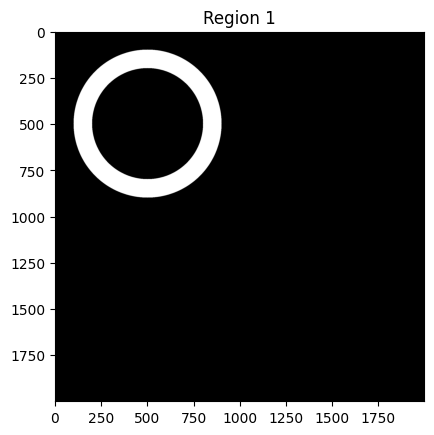

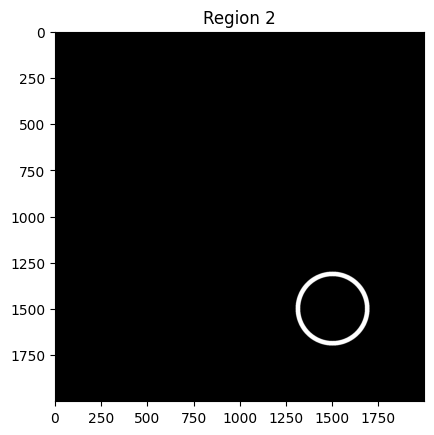

Mean Thickness across components: 62.49 pixels


In [11]:
import numpy as np
from scipy import ndimage
from skimage.measure import label, regionprops

def measure_component_thickness(mask, n_rays=360):
    """Compute mean thickness per connected component in a binary mask."""
    
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    all_thicknesses = []

    for region in regions:
        
        # Extract component mask and centroid
        component_mask = labeled_mask == region.label
        plt.imshow(component_mask, cmap='gray')
        plt.title(f"Region {region.label}")
        plt.show()

        cy, cx = region.centroid
        h, w = component_mask.shape
        r_max = int(np.hypot(h/2, w/2))

        # Sample rays around 360°
        thicknesses = []
        for angle in np.linspace(0, 2 * np.pi, n_rays, endpoint=False):
            xs = cx + np.cos(angle) * np.arange(r_max)
            ys = cy + np.sin(angle) * np.arange(r_max)

            vals = ndimage.map_coordinates(component_mask.astype(float), [ys, xs], order=0)

            # Find transitions: 0→1 (enter) and 1→0 (exit)
            diffs = np.diff(vals)
            enter_points = np.where(diffs == 1)[0]
            exit_points = np.where(diffs == -1)[0]

            # Pair them up to get thickness segments
            for e, x in zip(enter_points, exit_points):
                if x > e:
                    thicknesses.append(x - e)

        if len(thicknesses) > 0:
            mean_thickness = np.mean(thicknesses)
            all_thicknesses.append(mean_thickness)

    if len(all_thicknesses) == 0:
        return 0.0

    return np.mean(all_thicknesses)

mean_thickness = measure_component_thickness(bm, n_rays=360)
print(f"Mean Thickness across components: {mean_thickness:.2f} pixels")